# 1 Import Packages

In [1]:
import xarray as xr
import os
import numpy as np

In [2]:
import src.config as config
import src.utils as utils
from tqdm import tqdm
import math

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 2 Metadata

In [4]:
experiment_family = "GrandEnsemble"
experiment = "hist"
realization = "lkm0001"
processing = "mergetime_rho_remap_masked_ym"

filename_dict = dict(experiment_family = experiment_family,
experiment = experiment,
realization = realization)

In [16]:
problem_name = "streamfunction"

In [5]:
realization_id_list = np.arange(1, 100+1)

In [6]:
realization_list = ["lkm{}".format(str(realization_id).zfill(4)) for realization_id in realization_id_list]

In [7]:
def load_realization_list(realization_list, filename_dict, lev_index):
    file_list = []
    data_list = []
    for realization in tqdm(realization_list):
        filename_dict["realization"] = realization
        filename_dict["processing"] = "mergetime_rho_remap_masked_ym"

        path, filename = utils.gen_absolute_path_and_filename(
        filename_dict = filename_dict,
        init_path = config.data_pro_path, 
        init_filestem ="", 
        filetype="nc" 
        )

        file = os.path.join(path, filename)
        assert os.path.exists(file), "file {} does not exist".format(file)
        data = xr.open_dataset(file)["rho"].assign_coords({"realization": realization}).isel(lev=lev_index)
        data_list.append(data)
        
    return xr.concat(data_list, dim="realization")

In [8]:
def load_amoc_realization_list(realization_list, filename_dict):
    file_list = []
    data_list = []
    for realization in tqdm(realization_list):
        filename_dict["realization"] = realization
        filename_dict["processing"] = "amoc_ym"
        path, filename = utils.gen_absolute_path_and_filename(
        filename_dict = filename_dict,
        init_path = config.data_pro_path, 
        init_filestem ="", 
        filetype="nc" 
        )

        file = os.path.join(path, filename)
        assert os.path.exists(file), "file {} does not exist".format(file)
        data = xr.open_dataset(file)["atlantic_moc"].assign_coords({"realization": realization})
        data_list.append(data)
        
    return xr.concat(data_list, dim="realization")

# 3 Processing

In [57]:
lev_index=23

## 3.1 Load Data

In [58]:
data      = load_realization_list(realization_list, filename_dict, lev_index=lev_index)

  7%|▋         | 7/100 [00:10<02:14,  1.44s/it]

In [ ]:
data_amoc = load_amoc_realization_list(realization_list, filename_dict)


100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


In [ ]:
lev = data.lev
lon = data.lon
lat = data.lat

## 3.2 Feature scaling

### 3.2.1 Stack Data

In [ ]:
n_window = 20
years = data.time.dt.year.values

year_window_list = np.array_split(years, 8)


In [ ]:
valid_year_window_list = [years[20*i:20*(i+1)] for i in range(math.floor(len(years)/n_window))]

In [ ]:
train_year_window_list = [list(set(years).difference(valid_year)) for valid_year in valid_year_window_list]

In [ ]:
for i in tqdm(range(len(train_year_window_list))):

    train_data = data.where(data.time.dt.year.isin(train_year_window_list[i])).dropna(dim="time", how="all")
    valid_data = data.where(data.time.dt.year.isin(valid_year_window_list[i])).dropna(dim="time", how="all")
    
    train_data_stack = train_data.stack(sample= ("realization","time"))
    valid_data_stack = valid_data.stack(sample= ("realization","time"))
    
    train_data_stack_landmasked = train_data_stack.where(train_data_stack!=0)
    valid_data_stack_landmasked = valid_data_stack.where(valid_data_stack!=0)
    
    train_data_stack_samplemean = train_data_stack_landmasked.mean(dim="sample")
    train_data_stack_samplestd  = train_data_stack_landmasked.std(dim="sample")

    train_data_stack_sampleanom = train_data_stack_landmasked - train_data_stack_samplemean
    valid_data_stack_sampleanom = valid_data_stack_landmasked - train_data_stack_samplemean

    train_data_stack_samplestandardized = train_data_stack_sampleanom/train_data_stack_samplestd
    valid_data_stack_samplestandardized = valid_data_stack_sampleanom/train_data_stack_samplestd
    
    output_dir = os.path.join(config.data_pro_path, "ml_transform","cv", problem_name)
    os.makedirs(output_dir, exist_ok = True)

    train_data_stack_samplestandardized.unstack().to_netcdf(os.path.join(output_dir,"train_data_stack_samplestandardized_lev_{}_{}.nc".format(lev_index,i) ))
    valid_data_stack_samplestandardized.unstack().to_netcdf(os.path.join(output_dir,"valid_data_stack_samplestandardized_lev_{}_{}.nc".format(lev_index,i) ))
    

100%|██████████| 7/7 [01:13<00:00, 10.53s/it]


In [ ]:
depth_min = 0
depth_max = 2000

In [ ]:
lat_min = 0
lat_max = 60

In [ ]:
depth_mask = (data_amoc.depth_2>=depth_min)&(data_amoc.depth_2<=depth_max)
lat_mask = (data_amoc.lat >= lat_min) & (data_amoc.lat <=lat_max)

In [ ]:
data_amoc_crop = data_amoc.sel(depth_2=depth_mask).sel(lat = lat_mask)

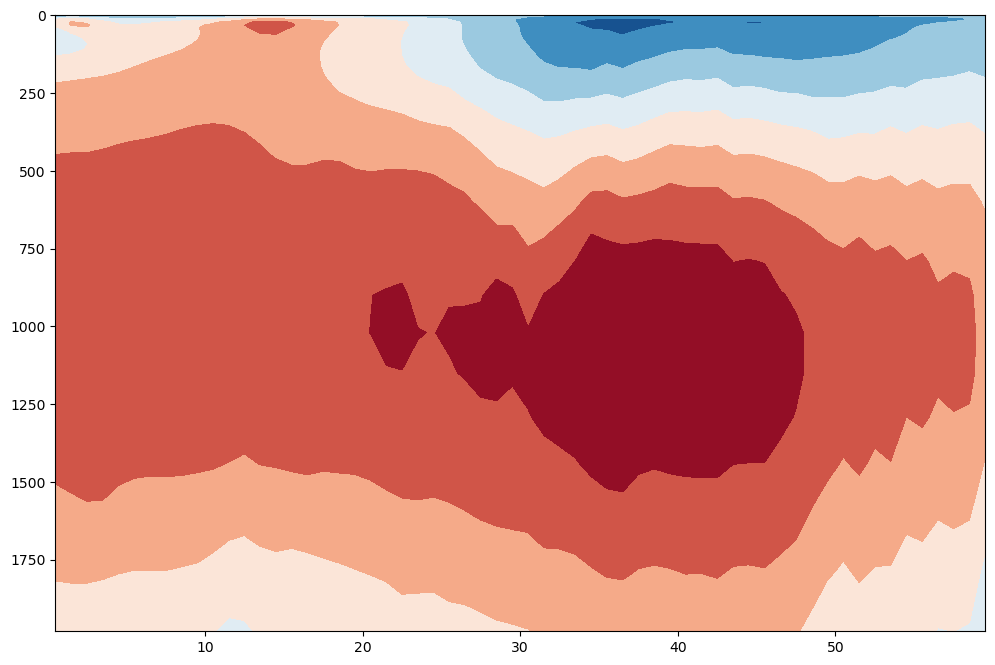

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.contourf(data_amoc_crop.lat, data_amoc_crop.depth_2,data_amoc_crop.isel(realization=0, time=0, lon=0), cmap="RdBu_r")

ax.invert_yaxis()

In [ ]:
for i in tqdm(range(len(train_year_window_list))):
    train_data_amoc = data_amoc.where(data_amoc.time.dt.year.isin(train_year_window_list[i])).dropna(dim="time", how="all")
    valid_data_amoc = data_amoc.where(data_amoc.time.dt.year.isin(valid_year_window_list[i])).dropna(dim="time", how="all")
    
    train_data_amoc_depth_mask_lat_mask = train_data_amoc.sel(depth_2 = depth_mask, lat= lat_mask).isel(lon=0)/(1025*10**6)
    valid_data_amoc_depth_mask_lat_mask = valid_data_amoc.sel(depth_2 = depth_mask, lat= lat_mask).isel(lon=0)/(1025*10**6)

    train_data_amoc_depth_mask_lat_mask_samplemean = train_data_amoc_depth_mask_lat_mask.mean()
    train_data_amoc_depth_mask_lat_mask_samplestd  = train_data_amoc_depth_mask_lat_mask.std()

    train_data_amoc_depth_mask_lat_mask_samplestandardized = (train_data_amoc_depth_mask_lat_mask - train_data_amoc_depth_mask_lat_mask_samplemean)/train_data_amoc_depth_mask_lat_mask_samplestd
    valid_data_amoc_depth_mask_lat_mask_samplestandardized = (valid_data_amoc_depth_mask_lat_mask - train_data_amoc_depth_mask_lat_mask_samplemean)/train_data_amoc_depth_mask_lat_mask_samplestd

    train_data_amoc_depth_mask_lat_mask_samplemean.to_netcdf(os.path.join(output_dir,"train_data_amoc_depth_mask_lat_mask_samplemean,nc"))
    train_data_amoc_depth_mask_lat_mask_samplestd.to_netcdf( os.path.join(output_dir, "train_data_amoc_depth_mask_lat_mask_samplestd.nc"))

    train_data_amoc_depth_mask_lat_mask_samplestandardized.to_netcdf(os.path.join(output_dir, "train_data_amoc_depth_mask_lat_mask_samplestandardized_{}_{}.nc".format(lev_index,i)))
    valid_data_amoc_depth_mask_lat_mask_samplestandardized.to_netcdf(os.path.join(output_dir, "valid_data_amoc_depth_mask_lat_mask_samplestandardized_{}_{}.nc".format(lev_index,i)))

100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


train_data_stack_landmasked_samplemean = train_data_stack_landmasked.mean(dim="sample")
train_data_stack_landmasked_samplestd = train_data_stack_landmasked.std(dim="sample")

valid_data_stack_landmasked_samplemean = valid_data_stack_landmasked.mean(dim="sample")
valid_data_stack_landmasked_samplestd = valid_data_stack_landmasked.std(dim="sample")

In [50]:
train_data_stack_lonlatanom = train_data_stack_landmasked - train_data_stack_lonlatmean
valid_data_stack_lonlatanom = valid_data_stack_landmasked - valid_data_stack_lonlatmean

In [51]:
train_data_stack_lonlatstandardized = train_data_stack_lonlatanom/train_data_stack_lonlatstd
valid_data_stack_lonlatstandardized = valid_data_stack_lonlatanom/valid_data_stack_lonlatstd

In [52]:
output_dir = os.path.join(config.data_pro_path, "ml_transform","cv")
os.makedirs(output_dir, exist_ok = True)

In [53]:
train_data_stack_lonlatstandardized.unstack().to_netcdf(os.path.join(output_dir,"train_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index,i) ))
valid_data_stack_lonlatstandardized.unstack().to_netcdf(os.path.join(output_dir,"valid_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index,i) ))

### 3.2.2 Mask land

In [20]:
train_data_stack_landmasked = train_data_stack.where(train_data_stack!=0)
valid_data_stack_landmasked = valid_data_stack.where(valid_data_stack!=0)

In [21]:
train_data_stack_landmasked_samplemean = train_data_stack_landmasked.mean(dim="sample")
train_data_stack_landmasked_samplestd = train_data_stack_landmasked.std(dim="sample")

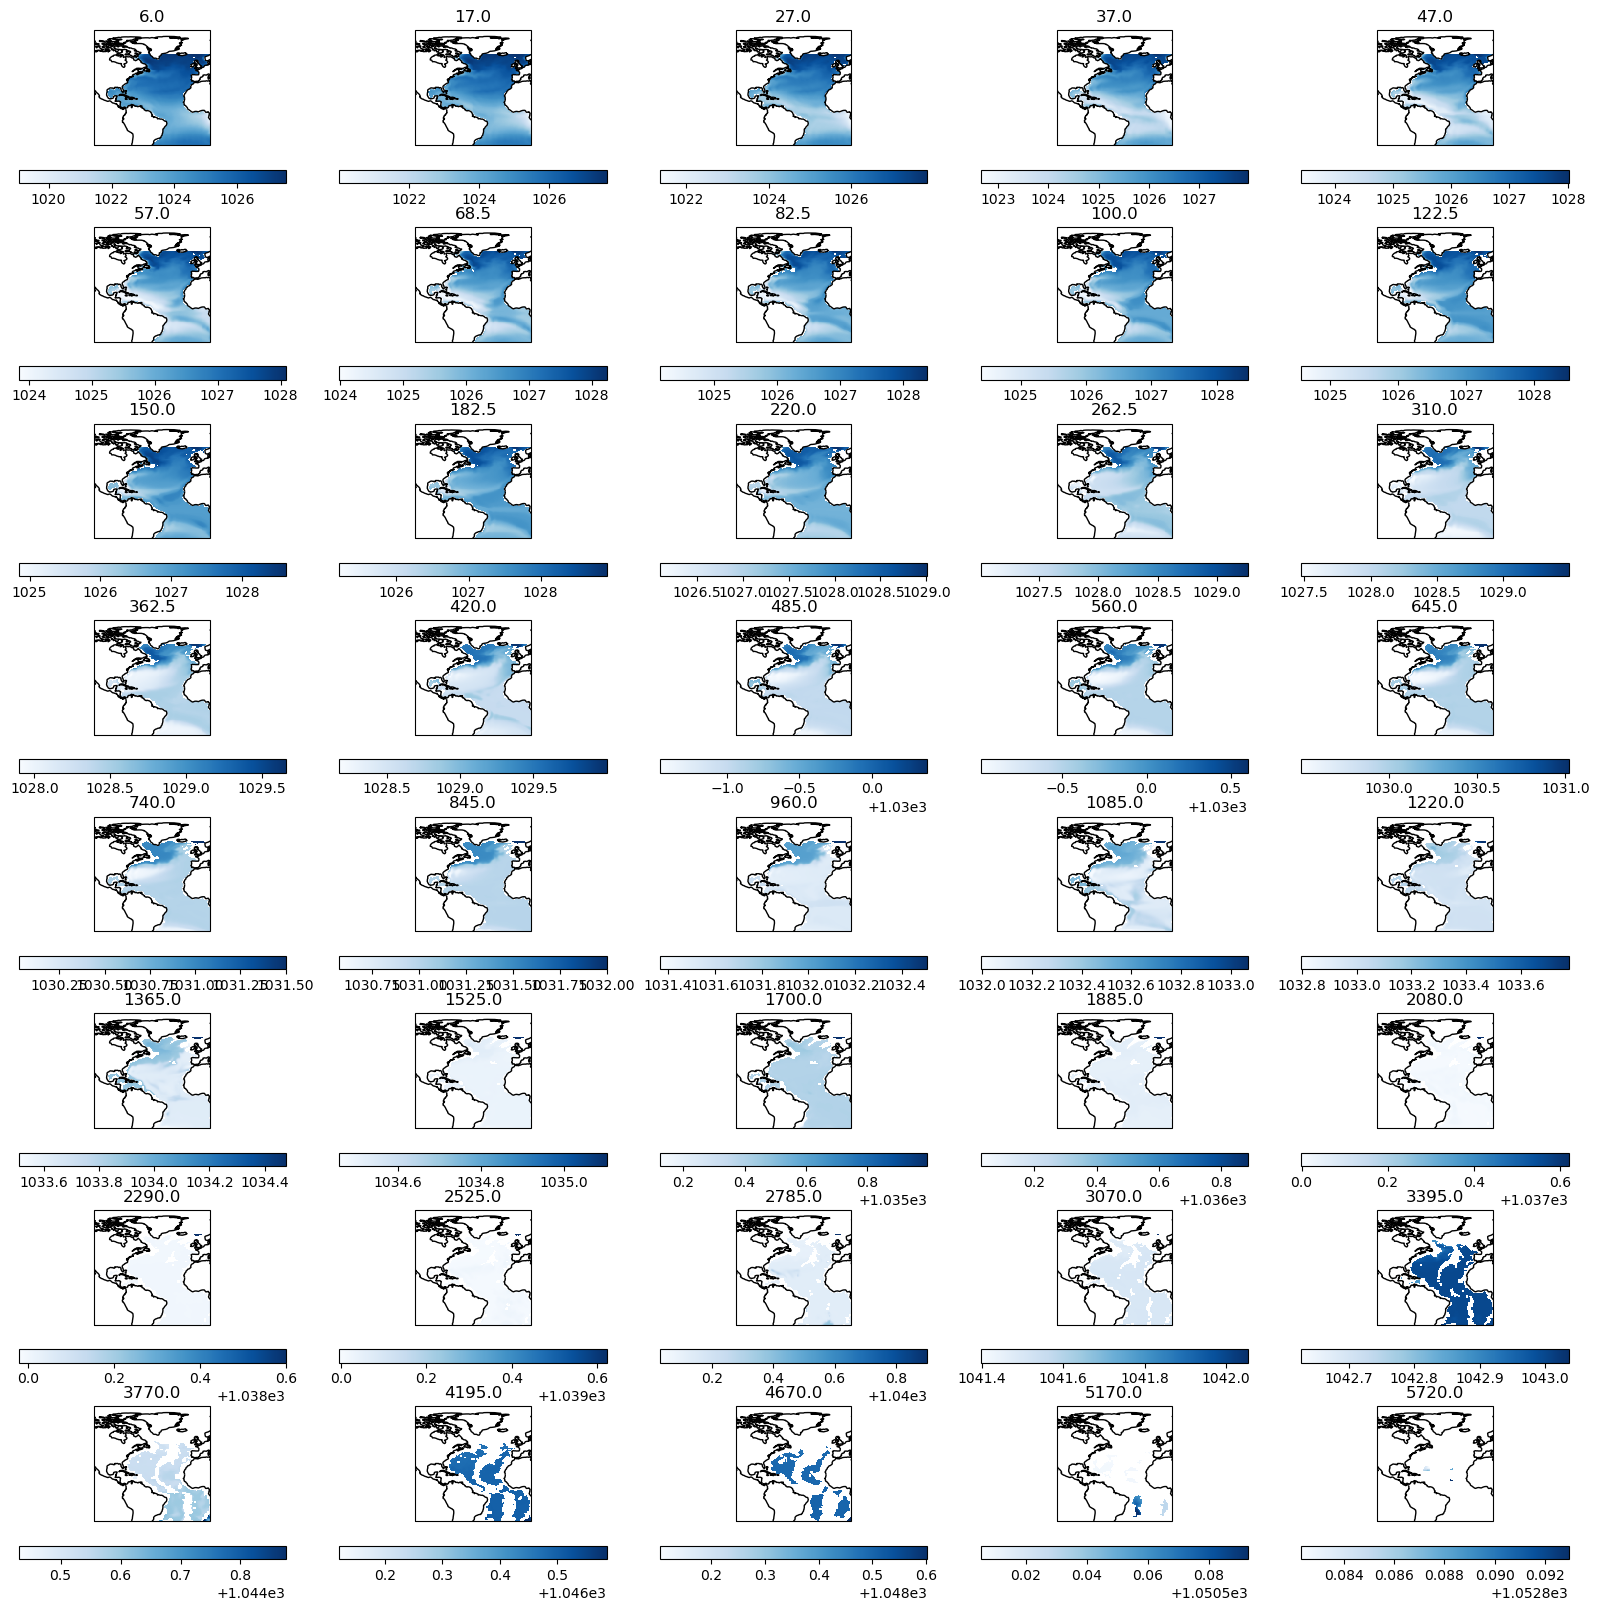

In [22]:
fig, ax = plt.subplots(8,5, figsize=(20,20), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)
for lev_index, lev_value in enumerate(lev):
    tmp = train_data_stack_landmasked_samplemean.sel(lev=lev_value)
    plot = ax_ravel[lev_index].pcolormesh(lon, lat, tmp, transform = ccrs.PlateCarree(), cmap="Blues")
    plt.colorbar(plot, ax = ax_ravel[lev_index], orientation="horizontal")
    ax_ravel[lev_index].coastlines()
    ax_ravel[lev_index].set_title(lev_value.values.item())



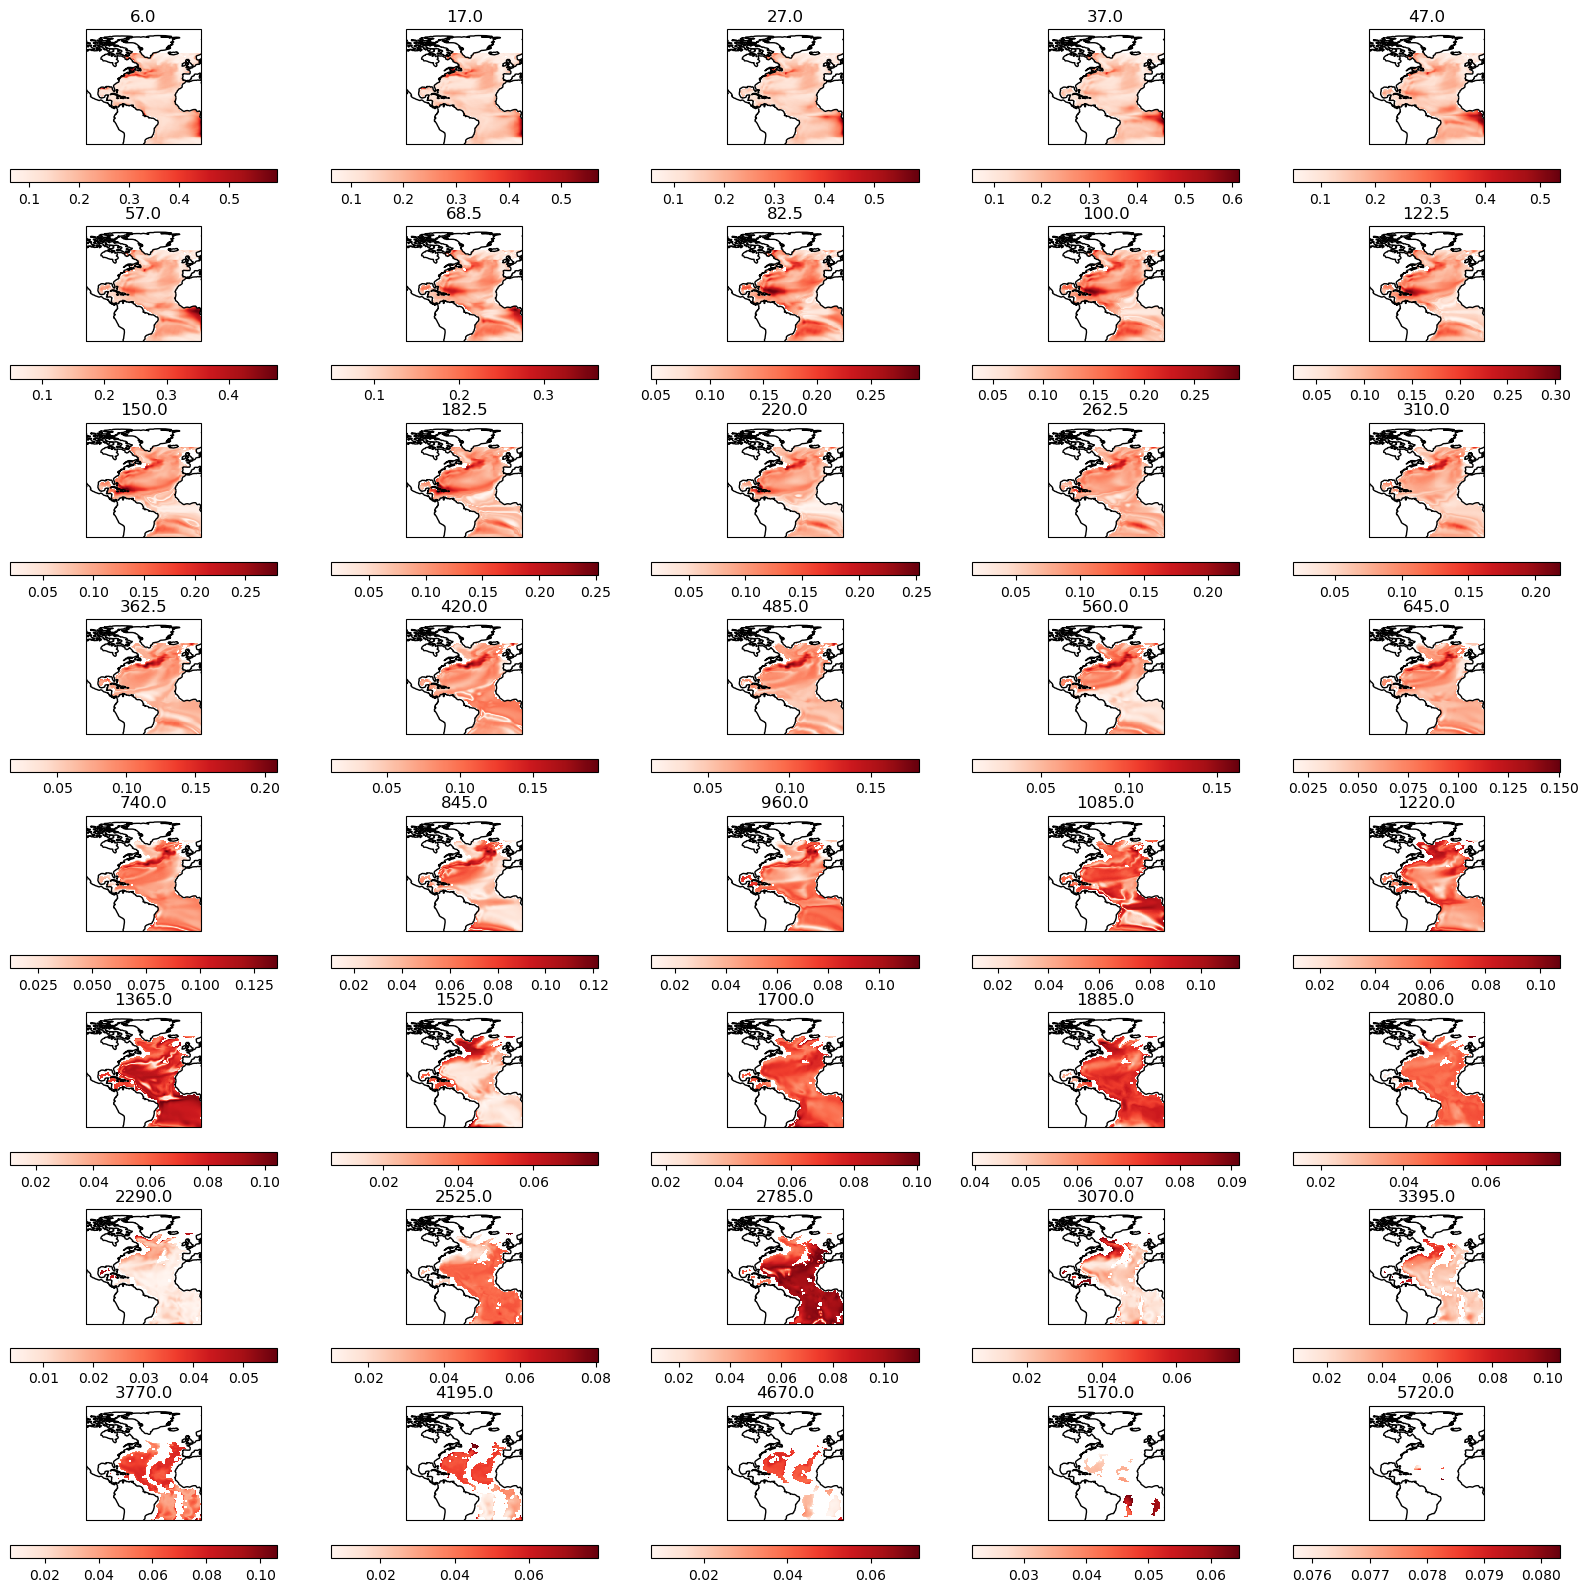

In [23]:
fig, ax = plt.subplots(8,5, figsize=(20,20), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)
for lev_index, lev_value in enumerate(lev):
    tmp = train_data_stack_landmasked_samplestd.sel(lev=lev_value)
    plot = ax_ravel[lev_index].pcolormesh(lon, lat, tmp, transform = ccrs.PlateCarree(), cmap="Reds")
    plt.colorbar(plot, ax = ax_ravel[lev_index], orientation="horizontal")
    ax_ravel[lev_index].coastlines()
    ax_ravel[lev_index].set_title(lev_value.values.item())


### 3.2.3 Calculate mean and standard deviation

In [37]:
train_data_stack_lonlatmean = train_data_stack_landmasked.mean(dim=("lat","lon"))
valid_data_stack_lonlatmean = valid_data_stack_landmasked.mean(dim=("lon","lat"))

In [38]:
train_data_stack_lonlatstd = train_data_stack_landmasked.std(dim=("lon","lat"))
valid_data_stack_lonlatstd = valid_data_stack_landmasked.std(dim=("lon","lat"))

### 3.2.4 Standardize

In [39]:
train_data_stack_lonlatanom = train_data_stack_landmasked - train_data_stack_lonlatmean
valid_data_stack_lonlatanom = valid_data_stack_landmasked - valid_data_stack_lonlatmean

In [40]:
train_data_stack_lonlatstandardized = train_data_stack_lonlatanom/train_data_stack_lonlatstd
valid_data_stack_lonlatstandardized = valid_data_stack_lonlatanom/valid_data_stack_lonlatstd

### 3.2.5 Save

In [41]:
output_dir = os.path.join(config.data_pro_path, "ml_transform")
os.makedirs(output_dir, exist_ok = True)

In [76]:
train_data_stack_lonlatstandardized.unstack().to_netcdf(os.path.join(output_dir,"train_data_stack_lonlatstandardized.nc" ))
valid_data_stack_lonlatstandardized.unstack().to_netcdf(os.path.join(output_dir,"valid_data_stack_lonlatstandardized.nc" ))

### 3.2.6 Plot Moments

In [44]:
train_data_stack_lonlatstandardized_samplemean = train_data_stack_lonlatstandardized.mean(dim="sample") 
train_data_stack_lonlatstandardized_samplestd = train_data_stack_lonlatstandardized.std(dim="sample") 

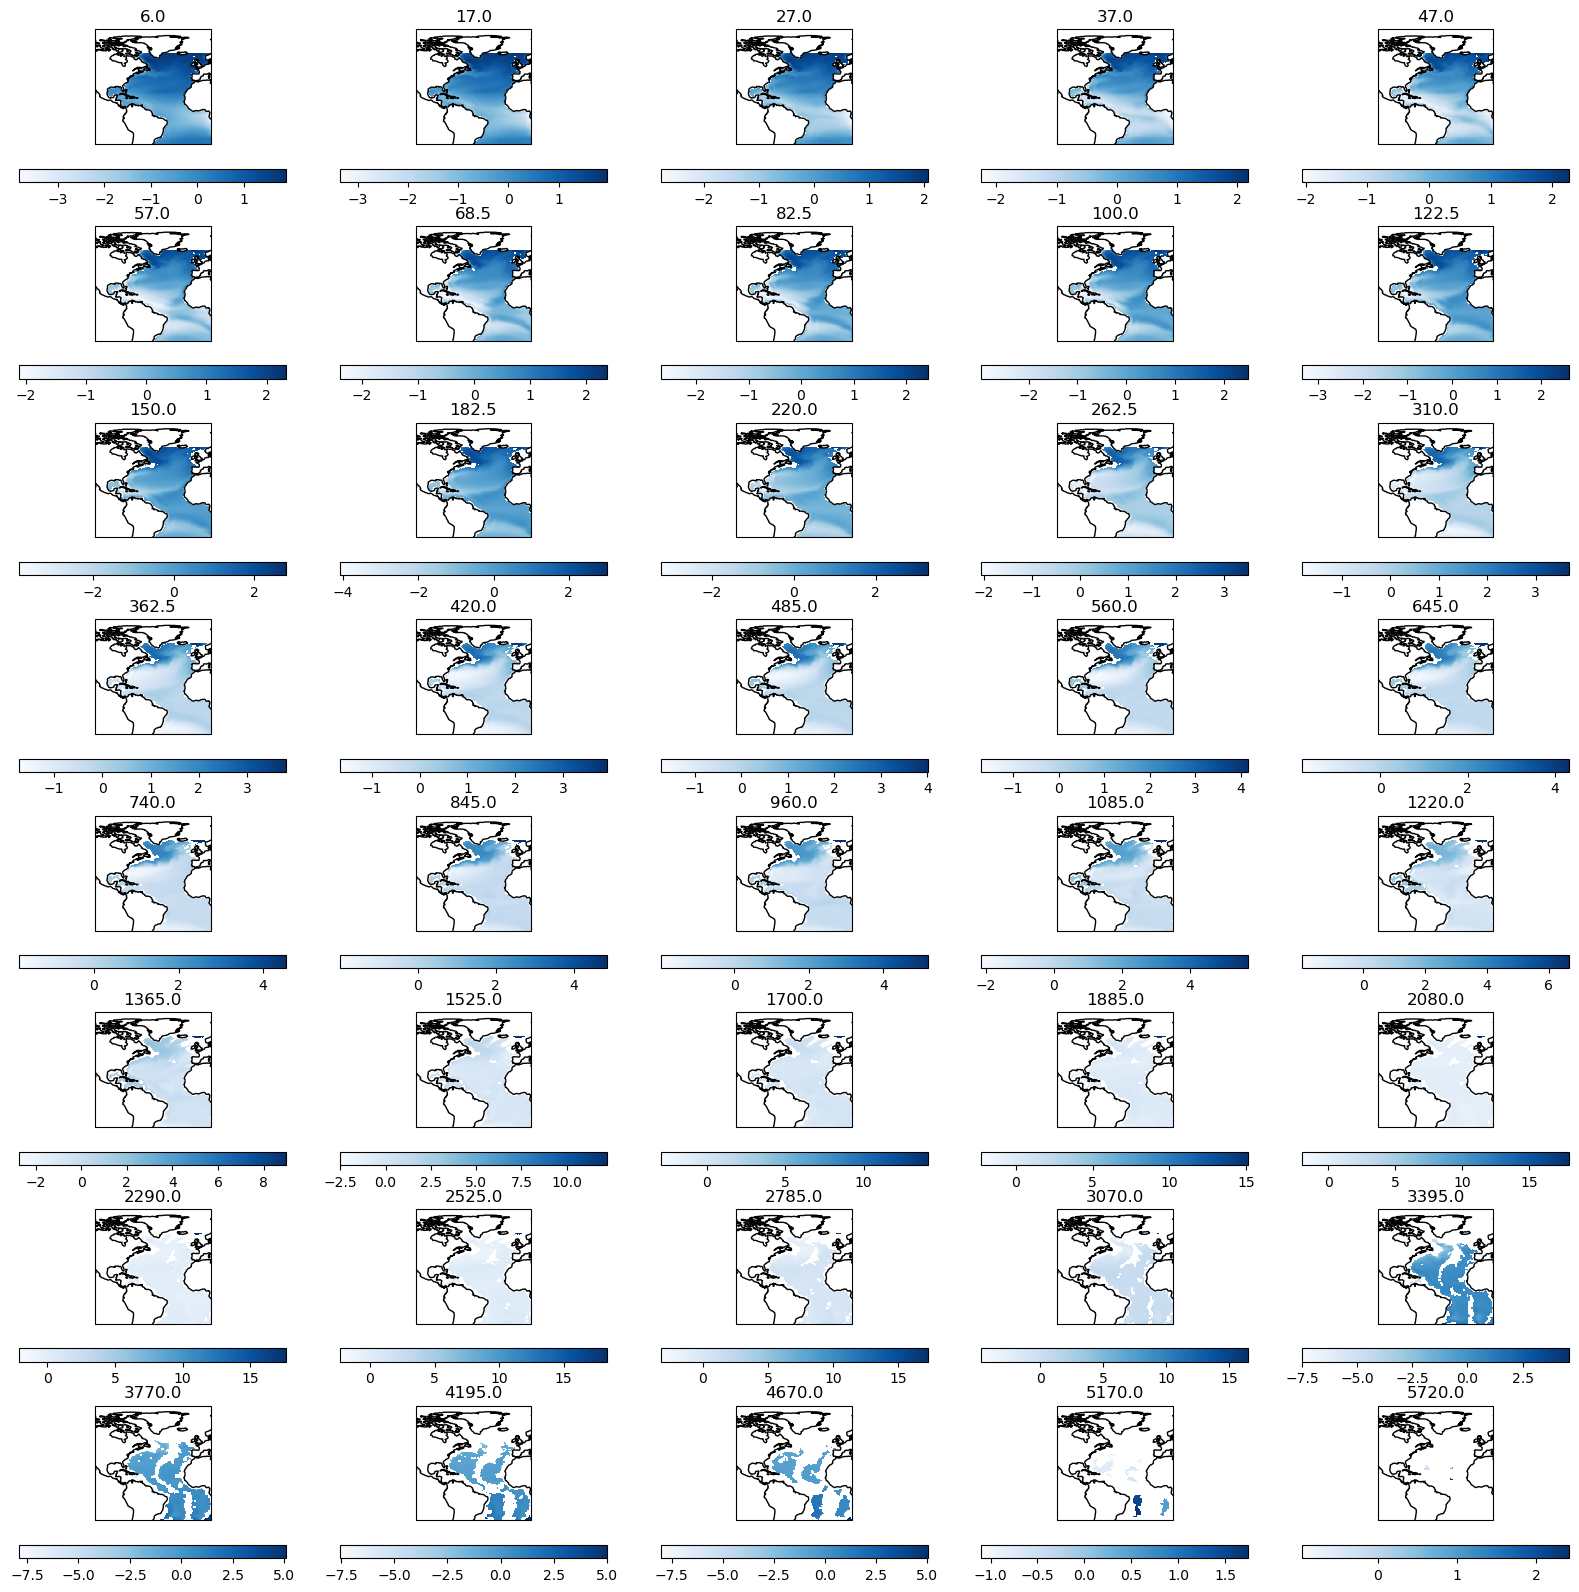

In [45]:
fig, ax = plt.subplots(8,5, figsize=(20,20), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)
for lev_index, lev_value in enumerate(lev):
    tmp = train_data_stack_lonlatstandardized_samplemean.sel(lev=lev_value)
    plot = ax_ravel[lev_index].pcolormesh(lon, lat, tmp, transform = ccrs.PlateCarree(), cmap="Blues")
    plt.colorbar(plot, ax = ax_ravel[lev_index], orientation="horizontal")
    ax_ravel[lev_index].coastlines()
    ax_ravel[lev_index].set_title(lev_value.values.item())

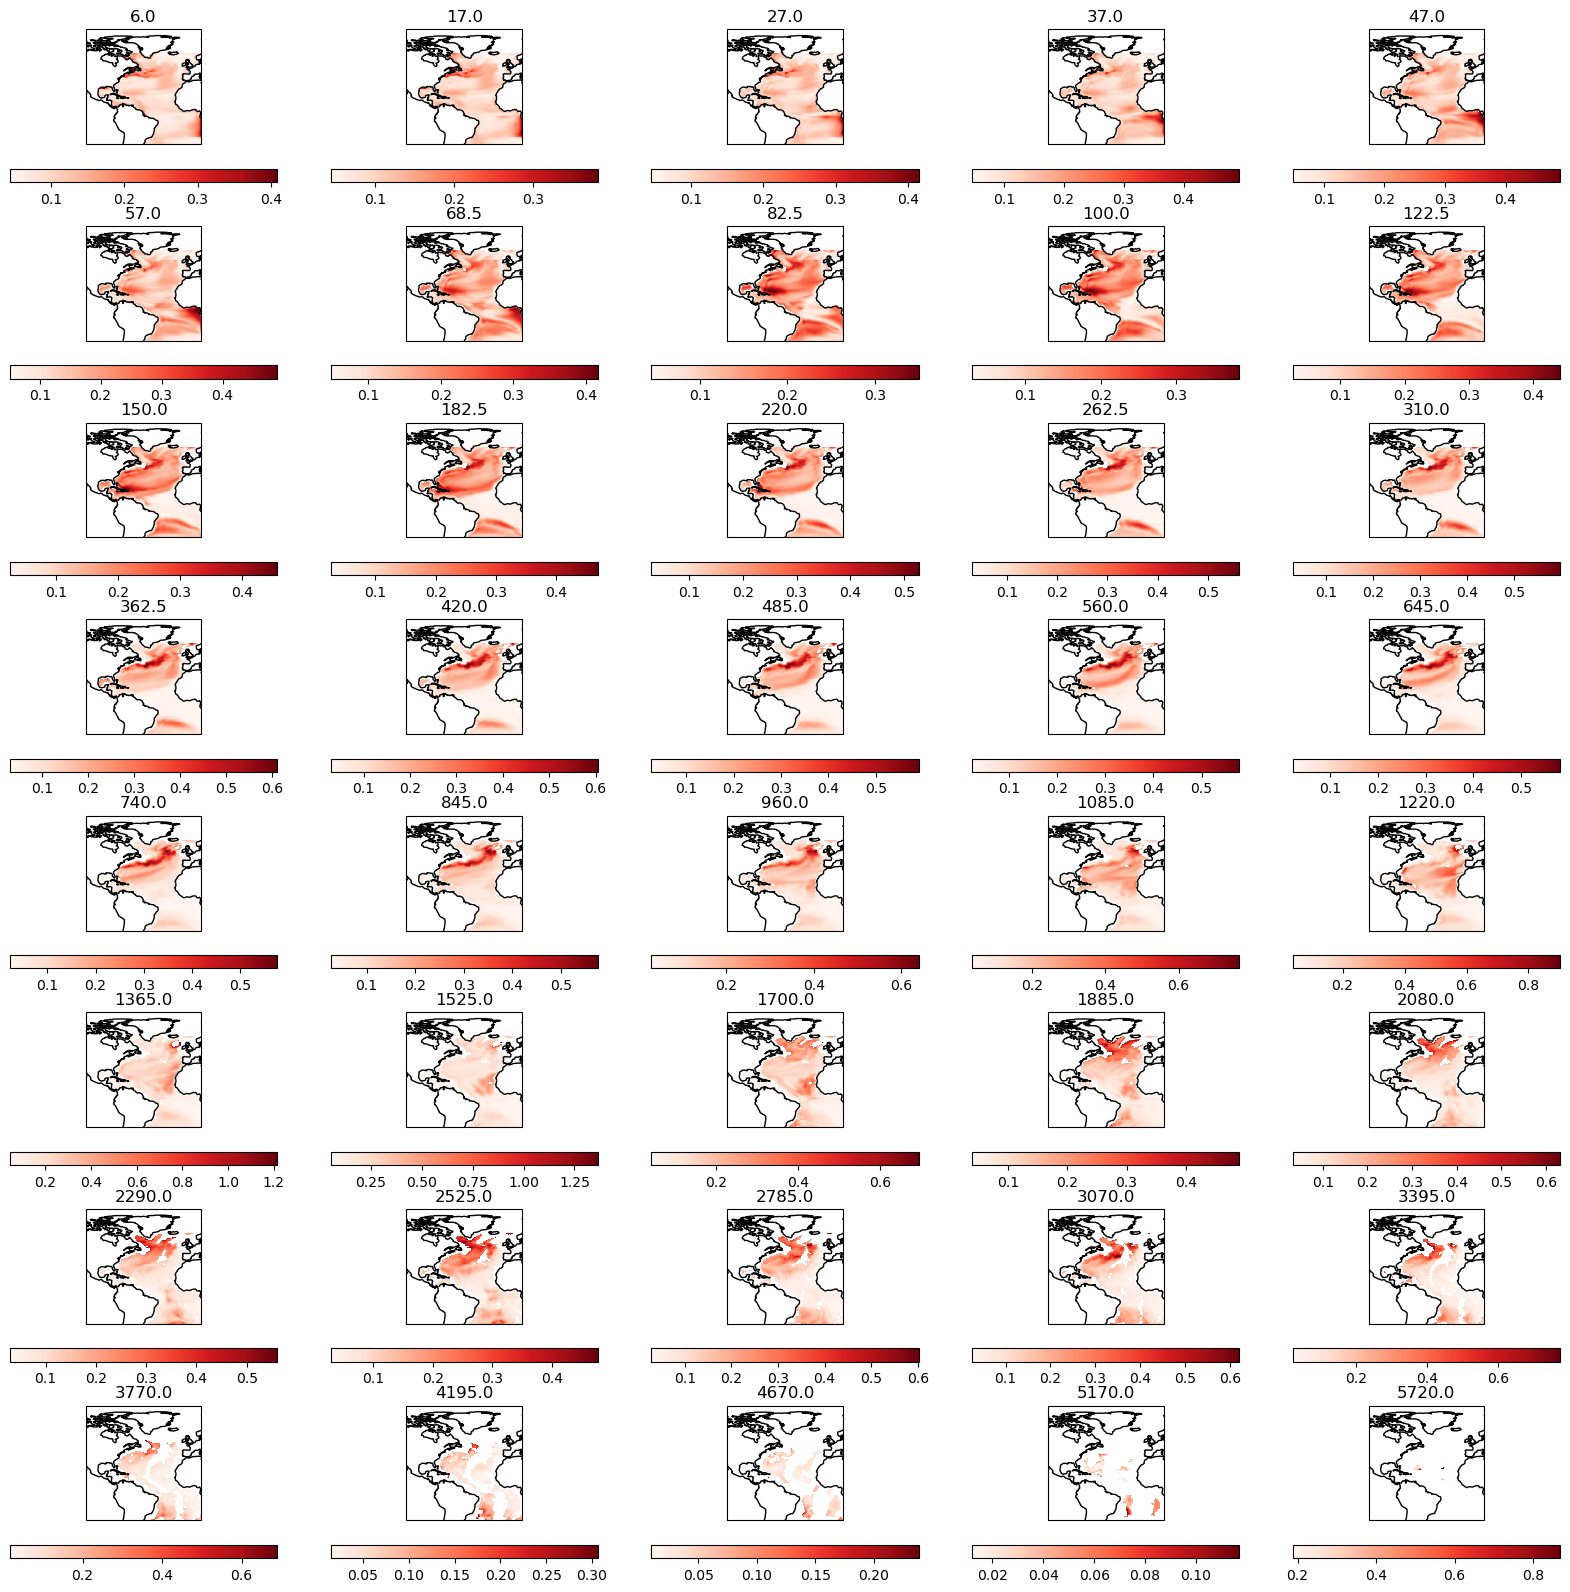

In [46]:
fig, ax = plt.subplots(8,5, figsize=(20,20), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)
for lev_index, lev_value in enumerate(lev):
    tmp = train_data_stack_lonlatstandardized_samplestd.sel(lev=lev_value)
    plot = ax_ravel[lev_index].pcolormesh(lon, lat, tmp, transform = ccrs.PlateCarree(), cmap="Reds")
    plt.colorbar(plot, ax = ax_ravel[lev_index], orientation="horizontal")
    ax_ravel[lev_index].coastlines()
    ax_ravel[lev_index].set_title(lev_value.values.item())


## 3.3 Process Output

### 3.3.1 Select Depth and Lat

In [47]:
amoc_depth = 1020
amoc_lat = 26.5

In [68]:
amoc_depth = 1020
amoc_lat = 26.5

train_data_amoc_depth_1020_lat_26 = train_data_amoc.sel(depth_2 = amoc_depth, lat= amoc_lat).isel(lon=0)/(1025*10**6)
valid_data_amoc_depth_1020_lat_26 = valid_data_amoc.sel(depth_2 = amoc_depth, lat= amoc_lat).isel(lon=0)/(1025*10**6)

train_data_amoc_depth_1020_lat_26_samplemean = train_data_amoc_depth_1020_lat_26.mean()
train_data_amoc_depth_1020_lat_26_samplestd = train_data_amoc_depth_1020_lat_26.std()

train_data_amoc_depth_1020_lat_26_samplestandardized = (train_data_amoc_depth_1020_lat_26 - train_data_amoc_depth_1020_lat_26_samplemean)/train_data_amoc_depth_1020_lat_26_samplestd
valid_data_amoc_depth_1020_lat_26_samplestandardized = (valid_data_amoc_depth_1020_lat_26 - train_data_amoc_depth_1020_lat_26_samplemean)/train_data_amoc_depth_1020_lat_26_samplestd

train_data_amoc_depth_1020_lat_26_samplemean.to_netcdf(os.path.join(output_dir,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))
train_data_amoc_depth_1020_lat_26_samplestd.to_netcdf( os.path.join(output_dir, "train_data_amoc_depth_1020_lat_26_samplestd.nc"))

train_data_amoc_depth_1020_lat_26_samplestandardized.to_netcdf(os.path.join(output_dir, "train_data_amoc_depth_1020_lat_26_samplestandardized.nc"))
valid_data_amoc_depth_1020_lat_26_samplestandardized.to_netcdf(os.path.join(output_dir, "valid_data_amoc_depth_1020_lat_26_samplestandardized.nc"))

### 3.3.2 Calculate Moments

In [69]:
train_data_amoc_depth_1020_lat_26_samplemean = train_data_amoc_depth_1020_lat_26.mean()
train_data_amoc_depth_1020_lat_26_samplestd = train_data_amoc_depth_1020_lat_26.std()

### 3.3.3 Standardize

In [70]:
train_data_amoc_depth_1020_lat_26_samplestandardized = (train_data_amoc_depth_1020_lat_26 - train_data_amoc_depth_1020_lat_26_samplemean)/train_data_amoc_depth_1020_lat_26_samplestd
valid_data_amoc_depth_1020_lat_26_samplestandardized = (valid_data_amoc_depth_1020_lat_26 - train_data_amoc_depth_1020_lat_26_samplemean)/train_data_amoc_depth_1020_lat_26_samplestd

In [75]:
train_data_amoc_depth_1020_lat_26_samplemean.to_netcdf(os.path.join(output_dir,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))
train_data_amoc_depth_1020_lat_26_samplestd.to_netcdf( os.path.join(output_dir, "train_data_amoc_depth_1020_lat_26_samplestd.nc"))

### 3.3.4 Save

In [73]:
train_data_amoc_depth_1020_lat_26_samplestandardized.to_netcdf(os.path.join(output_dir, "train_data_amoc_depth_1020_lat_26_samplestandardized.nc"))
valid_data_amoc_depth_1020_lat_26_samplestandardized.to_netcdf(os.path.join(output_dir, "valid_data_amoc_depth_1020_lat_26_samplestandardized.nc"))